In [43]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [44]:
# Ref : https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


In [45]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center",fontsize=7)
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [46]:
def plot_grid(V,ax):
    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.table(cellText=V, loc='center',bbox=None)

In [47]:
def transition_prob(A,w,S):
    P_a = np.zeros((100, 100, 4))
    for k in range(0,4):
        for i in range(0,10):
            for j in range(0,10):
                c_case = 0
                edge_case = False
                state = S[j][i].astype(int)
                
                for t in range (0,4):
                    #new X, y for the desired action cell
                    s_x = j + A[t][0]
                    s_y = i + A[t][1]
                    if(s_x < 0 or s_x > 9 or s_y < 0 or s_y > 9) :
                            
                        #Edge / Corner Case:
                        if t == k:
                            #I want to drift off the grid
                            c_case = c_case + 1 - w + w/4
                        else:
                            # i want to stay in the grid
                            c_case = c_case + w / 4
                        edge_case = True
                        continue
                    # I can move in a valid cell
                    s_ = s_x + s_y*10
                    if t == k:
                        pr = 1 - w + (w/4)
                    else:
                        pr = w/4
                    P_a[state, s_, k] = pr
                        
                if edge_case == True:
                    P_a[state, state, k] = c_case
                      
    return P_a

In [48]:
def value_iteration(S, A, R,G,w,thresh):
    V = np.zeros(100)
    #V.fill(-99.99)
    nav = np.zeros(100)
    delta = float('inf')
    while delta > thresh:
        delta = 0
        for i in range(0,10):
            for j in range(0,10):
                #convert state to numeric integer
                state = S[j][i].astype(int)
                v = V[state]
                v_k = np.zeros(4)
                #for each state , iterate through all 4 actions 'K'   
                for k in range(0,4):
                    res = 0
                    #iterate through all directions for a given actions
                    for t in range (0,4):
                        #new X, y for the desired action cell
                        s_x = j + A[t][0]
                        s_y = i + A[t][1]
                        if(s_x < 0 or s_x > 9 or s_y < 0 or s_y > 9) :
                            continue
                        # I can move in a valid cell    
                        s_ = s_x + s_y*10
                        res = res + P_a[state,s_,k]*(R[s_x][s_y] + G*V[s_])

                    res = res + P_a[state,state,k]*(R[i][j] + G*V[state])
                    v_k[k] = res
                V[state] = max(v_k[0], v_k[1],v_k[2],v_k[3])
                nav[state] = np.argmax(v_k)
                delta = max(delta, abs(v - V[state]))
    return (V, nav)

In [49]:
def get_nav_actions(S,nav):
    n = np.chararray((10,10),unicode=True)
    for i in range(0,10):
        for j in range(0,10):
            state = S[j][i].astype(int)
            if(nav[state] == 0):
                n[j][i] = u'\u2190'
            if(nav[state] == 1):
                n[j][i] = u'\u2191'
            if(nav[state] == 2):
                n[j][i] = u'\u2192'
            if(nav[state] == 3):
                n[j][i] = u'\u2193'
    return n

In [50]:
reward1= np.array([[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]])

In [51]:
reward2= np.array([[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,-100.0,-100.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,0.0,-100.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,0.0,-100.0,-100.0,-100.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,-100.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,-100.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,-100.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0,-100.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0]])
#print(reward2)

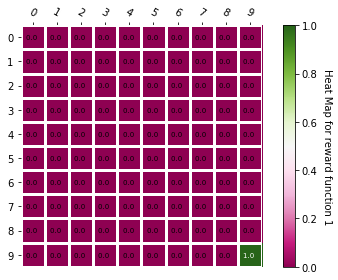

In [52]:
fig, ax = plt.subplots()
x_label = np.arange(np.size(reward1,1))
y_label = np.arange(np.size(reward1,0))
                    
im, cbar = heatmap(reward1, x_label, y_label, ax=ax,
                   cmap="PiYG", cbarlabel="Heat Map for reward function 1")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
plt.show()


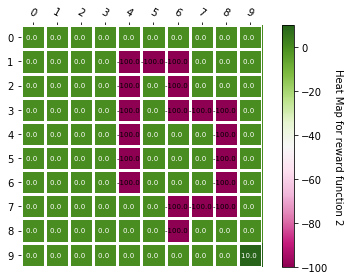

In [53]:
fig, ax = plt.subplots()
x_label = np.arange(np.size(reward1,1))
y_label = np.arange(np.size(reward1,0))
                    
im, cbar = heatmap(reward2, x_label, y_label, ax=ax,
                   cmap="PiYG", cbarlabel="Heat Map for reward function 2")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
plt.show()

### Question 2

### Creating environment

In [54]:
actions = np.array([[0,-1],[-1,0],[0,1],[1,0]]) # L U R D

states = np.zeros((10,10))

for i in range(0,10):
    for j in range(0,10):
        states[j][i] = i*10 + j

w = 0.1
gamma = 0.8
states.astype(int)
thresh = 0.01

#Get the 4 transition probabilities
P_a = transition_prob(actions,w,states)

In [55]:
resp, nav = value_iteration(states, actions, reward1,gamma,w,thresh)
grid = np.round(resp, decimals=3).reshape(10, 10).transpose()

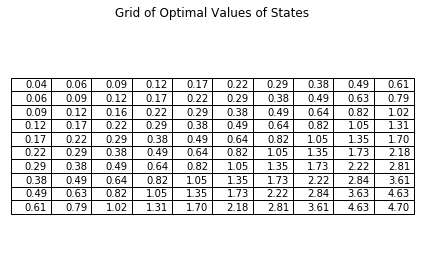

In [56]:
T = [['%.2f' % j for j in i] for i in grid]
fig, ax = plt.subplots()
plt.title("Grid of Optimal Values of States")
plot_grid(T,ax)
fig.tight_layout()
plt.show()

# Question 3

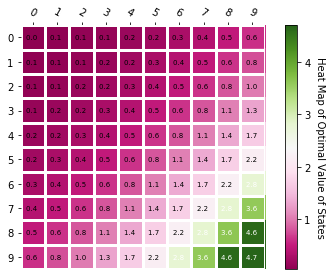

In [57]:
#g1 = np.round(V, decimals=3).reshape(10, 10).transpose()
fig, ax = plt.subplots()
x_label = np.arange(np.size(reward1,1))
y_label = np.arange(np.size(reward1,0))
                    
im, cbar = heatmap(grid, x_label, y_label, ax=ax,
                   cmap="PiYG", cbarlabel="Heat Map of Optimal Value of States")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
plt.show()


## Question 5

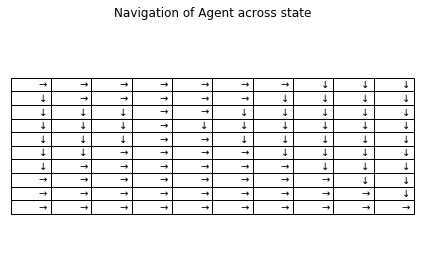

In [58]:
fig, ax = plt.subplots()
plt.title("Navigation of Agent across state")
plot_grid(get_nav_actions(states, nav),ax)
fig.tight_layout()
plt.show()

## Question 6

In [59]:
resp, nav = value_iteration(states, actions, reward2,gamma,w,thresh)
grid = np.round(resp, decimals=3).reshape(10, 10).transpose()

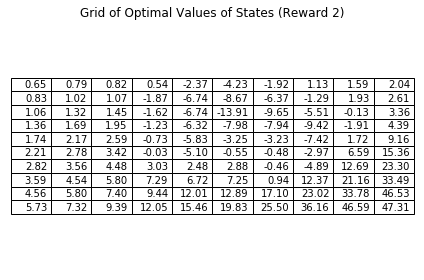

In [60]:
T = [['%.2f' % j for j in i] for i in grid]
fig, ax = plt.subplots()
plt.title("Grid of Optimal Values of States (Reward 2)")
plot_grid(T,ax)
fig.tight_layout()
plt.show()

### Question 7

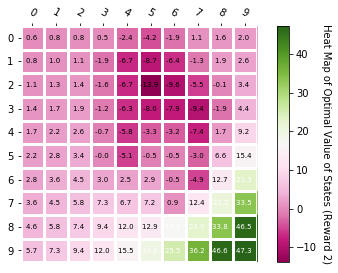

In [61]:
#g1 = np.round(V, decimals=3).reshape(10, 10).transpose()
fig, ax = plt.subplots()
x_label = np.arange(np.size(reward1,1))
y_label = np.arange(np.size(reward1,0))
                    
im, cbar = heatmap(grid, x_label, y_label, ax=ax,
                   cmap="PiYG", cbarlabel="Heat Map of Optimal Value of States (Reward 2)")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
plt.show()

## Question 9

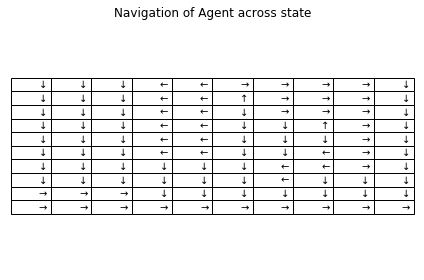

In [62]:
fig, ax = plt.subplots()
plt.title("Navigation of Agent across state")
plot_grid(get_nav_actions(states,nav),ax)
fig.tight_layout()
plt.show()